# Import & config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [3]:
import torch
import random
import numpy as np
from src.models import CustomDeepLabV3 as CDL
from src.utils.config import load_config
from src.data.transforms import build_transforms_from_config
from src.data.dataset import PancreasDataset
from torch.utils.data import DataLoader
from scripts.eval import visualize_model_predictions

# __Load model checkpoint and set eval__

In [4]:
MODEL_PATH = 'experiments/deep_aug_randcrop/deep_aug_randcrop_20250319_074330/checkpoints/best_model_epoch21.pth'
model = CDL(num_classes=5, dropout_rate=0.2, pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')['model']
model.load_state_dict(
    {k: v for k, v in checkpoint.items() if "aux_classifier" not in k},
    strict=False
)
model.eval();

In [7]:
config = load_config('configs/experiments/deep_aug_randcrop.yaml')
transform = build_transforms_from_config(config.get('transforms', None))
data_dir = config['data']['raw_dir'] + '/train'
val_dataset = PancreasDataset(
    data_dir=data_dir,
    split_file=config['data']['split_file'],
    split_type='val',
    transform=transform
)

📊 Loading dataset (val)... 12 patients found.
📊 Dataset loaded with 1305 slices.


In [8]:
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=True
)

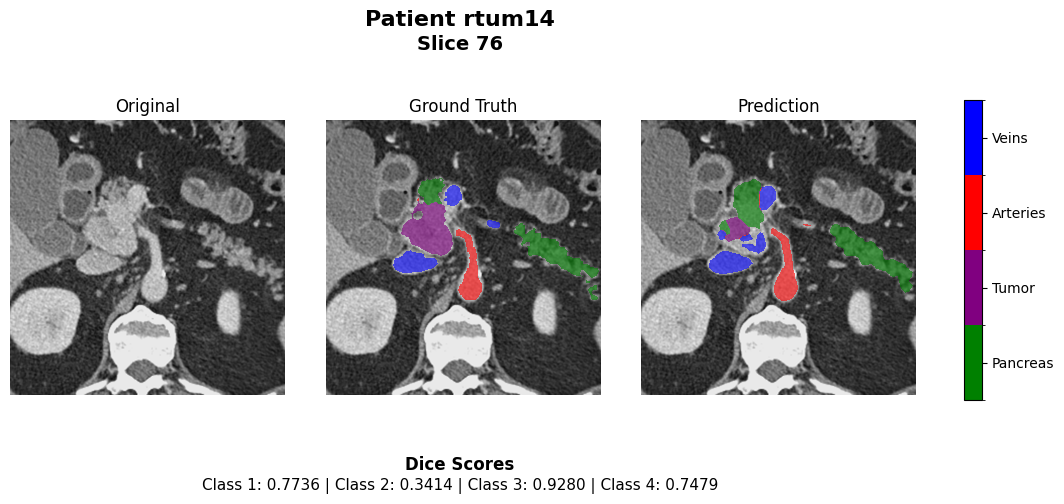

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_predictions(model, val_loader, device, 1)

# __New class__

In [12]:
import torch

class SegmentationMetricsAccumulator:
    def __init__(self, num_classes, absent_class_strategy="one"):
        """
        Parameters
        ----------
        num_classes : int
            Number of classes in the segmentation task.
        absent_class_strategy : str
            What to do when a class is absent in both prediction and ground truth.
            Options: "nan", "one", "skip", "zero"
        """
        self.num_classes = num_classes
        self.absent_class_strategy = absent_class_strategy
        self.reset()

    def reset(self):
        self.tp = torch.zeros(self.num_classes)
        self.fp = torch.zeros(self.num_classes)
        self.fn = torch.zeros(self.num_classes)
        self.support = torch.zeros(self.num_classes)
        self.count = 0

    @staticmethod
    def convert_to_one_hot(y_pred, y_true, num_classes):
        if y_pred.dim() == y_true.dim():  # Both are likely one-hot
            return y_pred, y_true
        y_pred = torch.argmax(y_pred, dim=1) if y_pred.dim() > y_true.dim() else y_pred
        y_pred_oh = torch.nn.functional.one_hot(y_pred, num_classes).permute(0, -1, *range(1, y_pred.dim()))
        y_true_oh = torch.nn.functional.one_hot(y_true, num_classes).permute(0, -1, *range(1, y_true.dim()))
        return y_pred_oh.float(), y_true_oh.float()

    def update(self, y_pred, y_true):
        y_pred_oh, y_true_oh = self.convert_to_one_hot(y_pred, y_true, self.num_classes)
        dims = tuple(range(2, y_pred_oh.ndim))

        tp = torch.sum(y_pred_oh * y_true_oh, dim=dims)
        fp = torch.sum(y_pred_oh, dim=dims) - tp
        fn = torch.sum(y_true_oh, dim=dims) - tp
        support = torch.sum(y_true_oh, dim=dims)

        self.tp += tp.sum(dim=0).cpu()
        self.fp += fp.sum(dim=0).cpu()
        self.fn += fn.sum(dim=0).cpu()
        self.support += support.sum(dim=0).cpu()
        self.count += y_pred.shape[0]

    def _apply_absent_class_strategy(self, value_tensor, mask):
        if self.absent_class_strategy == "nan":
            value_tensor[mask] = float("nan")
        elif self.absent_class_strategy == "one":
            value_tensor[mask] = 1.0
        elif self.absent_class_strategy == "zero":
            value_tensor[mask] = 0.0
        elif self.absent_class_strategy == "skip":
            pass  # Just leave it as is (to be excluded from mean)
        return value_tensor

    def aggregate(self):
        eps = 1e-12
        precision = self.tp / (self.tp + self.fp + eps)
        recall = self.tp / (self.tp + self.fn + eps)
        dice = 2 * self.tp / (2 * self.tp + self.fp + self.fn + eps)
        iou = self.tp / (self.tp + self.fp + self.fn + eps)

        # Mask classes with no presence
        mask = (self.tp + self.fp + self.fn) == 0
        precision = self._apply_absent_class_strategy(precision, mask)
        recall = self._apply_absent_class_strategy(recall, mask)
        dice = self._apply_absent_class_strategy(dice, mask)
        iou = self._apply_absent_class_strategy(iou, mask)

        metrics = {f"dice_class_{i}": dice[i].item() for i in range(self.num_classes)}
        metrics.update({f"iou_class_{i}": iou[i].item() for i in range(self.num_classes)})
        metrics.update({f"precision_class_{i}": precision[i].item() for i in range(self.num_classes)})
        metrics.update({f"recall_class_{i}": recall[i].item() for i in range(self.num_classes)})

        # Calculate means excluding NaNs
        metrics["precision"] = torch.nanmean(precision).item()
        metrics["recall"] = torch.nanmean(recall).item()
        metrics["dice"] = torch.nanmean(dice).item()
        metrics["iou"] = torch.nanmean(iou).item()

        return metrics

## `generate_predictions`

In [11]:
def generate_predictions(model, test_loader, device):
    model.eval()

    # for i, idx in enumerate(indices):
    with torch.no_grad():
        for image, mask, _ in test_loader: 
            image, mask = image.to(device), mask.to(device)

            output = model(image)["out"]
            print(f"Ouptut shape: {output.shape}")
            print(f"Mask shape: {mask.shape}")

            return output, mask

# __Test__

In [13]:
from src.metrics.segmentation import SegmentationMetrics

In [14]:
output, masks = generate_predictions(model, val_loader, device)

Ouptut shape: torch.Size([4, 5, 512, 512])
Mask shape: torch.Size([4, 512, 512])


In [15]:
SMA = SegmentationMetricsAccumulator(num_classes=5)

In [16]:
SMA.reset()
SMA.update(output, masks)

In [17]:
antes = SegmentationMetrics.all_metrics(output, masks)
ahora = SMA.aggregate()

In [18]:
print(antes)
print('-'*65)
print(ahora)

{'dice_class_0': 0.9961274862289429, 'dice_class_1': 0.0, 'dice_class_2': 0.0, 'dice_class_3': 0.0, 'dice_class_4': 0.4441978335380554, 'dice_mean': 0.2880650460720062, 'iou_class_0': 0.9922880530357361, 'iou_class_1': 0.0, 'iou_class_2': 0.0, 'iou_class_3': 0.0, 'iou_class_4': 0.399849534034729, 'iou_mean': 0.27842751145362854, 'precision_class_0': 0.9992117285728455, 'precision_class_1': 0.0, 'precision_class_2': 0.0, 'precision_class_3': 0.0, 'precision_class_4': 0.4893980324268341, 'recall_class_0': 0.9930706024169922, 'recall_class_1': 0.0, 'recall_class_2': 0.0, 'recall_class_3': 0.0, 'recall_class_4': 0.40673142671585083, 'dice': 0.2880650460720062, 'iou': 0.27842751145362854, 'precision': 0.2977219521999359, 'recall': 0.27996039390563965}
-----------------------------------------------------------------
{'dice_class_0': 0.9961248636245728, 'dice_class_1': 0.0, 'dice_class_2': 0.0, 'dice_class_3': 0.0, 'dice_class_4': 0.6102335453033447, 'iou_class_0': 0.992279589176178, 'iou_cl

In [ ]:
def dice_monai(y_pred, y_true, verbose=False):
    from monai.metrics import DiceMetric
    def convert_to_one_hot(y_pred, y_true):
        def is_one_hot(tensor):
            """
            Check if the tensor is one-hot encoded.
            """
            return (tensor.sum(dim=1) == 1).all() and \
                   torch.all((tensor == 0) | (tensor == 1))
        
        # Check if the input is already one-hot encoded
        if is_one_hot(y_pred) and is_one_hot(y_true):
            return y_pred, y_true
        
        # Check if the input is 2D or 3D
        if y_pred.dim() == 4 and y_true.dim() == 3: # 2D case
            B, C, H, W = y_pred.shape
            n_classes = C
    
            # Convert y_pred to one-hot encoding
            y_pred_classes = torch.argmax(y_pred, dim=1, keepdim=True)
            y_pred_one_hot = torch.zeros(B, n_classes, H, W, device=y_pred.device)
            y_pred_one_hot.scatter_(1, y_pred_classes, 1)
    
            # Convert y_true to one-hot encoding
            y_true_one_hot = torch.zeros(B, n_classes, H, W, device=y_true.device)
            y_true_one_hot.scatter_(1, y_true.unsqueeze(1).long(), 1)
    
            return y_pred_one_hot, y_true_one_hot
        
        elif y_pred.dim() == 5 and y_true.dim() == 4:   # 3D case
            B, C, D, H, W = y_pred.shape
            n_classes = C
    
            # Convert y_pred to one-hot encoding
            y_pred_classes = torch.argmax(y_pred, dim=1, keepdim=True)
            y_pred_one_hot = torch.zeros(B, n_classes, D, H, W, device=y_pred.device)
            y_pred_one_hot.scatter_(1, y_pred_classes, 1)
    
            # Convert y_true to one-hot encoding
            y_true_one_hot = torch.zeros(B, n_classes, D, H, W, device=y_true.device)
            y_true_one_hot.scatter_(1, y_true.unsqueeze(1).long(), 1)
    
            return y_pred_one_hot, y_true_one_hot
    
        else:
            raise ValueError("Input tensors must be either 2D or 3D.")
    dmm = DiceMetric(
        include_background=True,
        reduction='mean_batch',
        get_not_nans=False,
        ignore_empty=False,
        num_classes=None,
        return_with_label=False
    )
    y_pred_one_hot, y_true_one_hot = convert_to_one_hot(y_pred, y_true)
    C = y_true_one_hot.size(1)
    start = 0
    monai_dice = dmm(y_pred_one_hot, y_true_one_hot)
    if verbose:
        print(f"dice_monai before aggregate:\n{monai_dice}")

    monai_dice = dmm.aggregate()
    if verbose:
        print(f"dice_monai after aggregate:\n{monai_dice}")

    dice_dict = {f"dice_class_{i}": monai_dice[i].item() for i in range(start, C)}
    dice_dict["dice_mean"] = monai_dice.mean().item()
    
    return monai_dice.mean(), dice_dict

In [ ]:
monai_dice = dice_monai(output, masks)
print(monai_dice)

# __Test 2__

In [26]:
def convert_to_one_hot(y_pred, y_true):
    def is_one_hot(tensor):
        """
        Check if the tensor is one-hot encoded.
        """
        return (tensor.sum(dim=1) == 1).all() and \
               torch.all((tensor == 0) | (tensor == 1))
    
    # Check if the input is already one-hot encoded
    if is_one_hot(y_pred) and is_one_hot(y_true):
        return y_pred, y_true
    
    # Check if the input is 2D or 3D
    if y_pred.dim() == 4 and y_true.dim() == 3: # 2D case
        B, C, H, W = y_pred.shape
        n_classes = C

        # Convert y_pred to one-hot encoding
        y_pred_classes = torch.argmax(y_pred, dim=1, keepdim=True)
        y_pred_one_hot = torch.zeros(B, n_classes, H, W, device=y_pred.device)
        y_pred_one_hot.scatter_(1, y_pred_classes, 1)

        # Convert y_true to one-hot encoding
        y_true_one_hot = torch.zeros(B, n_classes, H, W, device=y_true.device)
        y_true_one_hot.scatter_(1, y_true.unsqueeze(1).long(), 1)

        return y_pred_one_hot, y_true_one_hot
    
    elif y_pred.dim() == 5 and y_true.dim() == 4:   # 3D case
        B, C, D, H, W = y_pred.shape
        n_classes = C

        # Convert y_pred to one-hot encoding
        y_pred_classes = torch.argmax(y_pred, dim=1, keepdim=True)
        y_pred_one_hot = torch.zeros(B, n_classes, D, H, W, device=y_pred.device)
        y_pred_one_hot.scatter_(1, y_pred_classes, 1)

        # Convert y_true to one-hot encoding
        y_true_one_hot = torch.zeros(B, n_classes, D, H, W, device=y_true.device)
        y_true_one_hot.scatter_(1, y_true.unsqueeze(1).long(), 1)

        return y_pred_one_hot, y_true_one_hot

    else:
        raise ValueError("Input tensors must be either 2D or 3D.")

def compute_tp_fp_fn(y_pred, y_true):
    print("y_pred:", y_pred.shape)
    print("y_true:", y_true.shape)
    y_pred_oh, y_true_oh = convert_to_one_hot(y_pred, y_true)
    print("y_pred_oh:", y_pred_oh.shape)
    print("y_true_oh:", y_true_oh.shape)
    dims = tuple(range(2, y_pred_oh.ndim))

    tp = torch.sum(y_pred_oh * y_true_oh, dim=dims)
    fp = torch.sum(y_pred_oh, dim=dims) - tp
    fn = torch.sum(y_true_oh, dim=dims) - tp

    print(tp.shape)
    print(fp.shape)
    print(fn.shape)

    return tp, fp, fn

def manage_zeros(values, mask, method="nan"):
    if method=='nan':
        values[mask > 0] = float('nan')
    elif method=='one':
        values[mask > 0] = 1.0
    return values

def compute_dice(tp, fp, fn, method='nan'):
    B = tp.size(0)
    C = tp.size(1)
    dices = (2. * tp) / (2. * tp + fp + fn + 1e-12)
    invalid = (tp + fp + fn) == 0
    
    return manage_zeros(dices, invalid, method)

def compute_iou(tp, fp, fn, method='nan'):
    iou = tp / (tp + fp + fn + 1e-12)
    # Handle zero division cases
    mask = (tp + fp + fn) == 0

    return manage_zeros(iou, mask, method)

def compute_precision(tp, fp, method='nan'):
    precision = tp / (tp + fp + 1e-12)
    # Handle zero division cases
    mask = (tp + fp) == 0

    return manage_zeros(precision, mask, method)

def compute_recall(tp, fn, method='nan'):
    recall = tp / (tp + fn + 1e-12)
    # Handle zero division cases
    mask = (tp + fn) == 0

    return manage_zeros(recall, mask, method)
    

In [ ]:
class acum:
    def __init__(self):
        self.reset()

    def reset(self):
        self.dices = None
        
    def update(self, tp, fp, fn):
        dices = compute_dice(tp, fp, fn, method='nan')
        if self.dices is None:
            self.dices = dices
        else:
            self.dices = torch.cat([self.dices, dices], dim=0)


    def print(self):
        print(self.dices)


    def aggregate(self):
        return torch.nanmean(self.dices, dim=0)

In [ ]:
tp, fp, fn = compute_tp_fp_fn(output, masks)
print(tp)
print(fp)
print(fn)

In [ ]:
newdices_nan = compute_dice(tp, fp, fn, method='nan')
newdices_one = compute_dice(tp, fp, fn, method='one')

In [ ]:
print(newdices_nan)
print('-'*65)
print(newdices_one)
print(torch.nanmean(newdices_one, dim=0))

In [ ]:
monai_dice = dice_monai(output, masks, True)
print(monai_dice)

In [ ]:
A = acum()
A.update(tp, fp, fn)
A.print()
total = A.aggregate()
print(total)

In [ ]:
A.update(tp, fp, fn)
A.print()

In [ ]:
total = A.aggregate()
print(total)

## All metrics

In [ ]:
nd = compute_dice(tp, fp, fn, method='one')
print(nd)
print('-'*65)
niou = compute_iou(tp, fp, fn, method='one')
print(niou)
print('-'*65)
np = compute_precision(tp, fp, method='one')
print(np)
print('-'*65)
nr = compute_recall(tp, fn, method='one')
print(nr)

In [ ]:
from monai.metrics import MeanIoU
mmiou = MeanIoU(ignore_empty=False)

In [ ]:
y_pred_oh, y_true_oh = convert_to_one_hot(output, masks)
monai_iou = mmiou(y_pred_oh, y_true_oh)
print(monai_iou)

In [24]:
def check_presence(y_pred, y_true):
    y_pred_oh, y_true_oh = convert_to_one_hot(y_pred, y_true)
    dims = tuple(range(2, y_pred_oh.ndim))
    presence = torch.sum(y_pred_oh, dim=dims) + torch.sum(y_true_oh, dim=dims)
    presence = presence == 0
    print(presence)

def check_presence_2(y_pred, y_true):
    y_pred_oh, y_true_oh = convert_to_one_hot(y_pred, y_true)
    dims = tuple(range(2, y_pred_oh.ndim))
    presence = torch.sum(y_pred_oh + y_true_oh, dim=dims)
    presence = presence == 0
    print(presence)

def check_presence_long(y_pred, y_true):
    pred, gt = convert_to_one_hot(y_pred, y_true)
    B = gt.size(0)
    C = gt.size(1)

    print(f"{'INDEX':<10}{'PANCREAS':<14}{'TUMOR':<14}{'ARTERIES':<14}{'VEINS':<14}")
    print(f"{'':<10}{'Pred':<7}{'Mask':<7}{'Pred':<7}{'Mask':<7}{'Pred':<7}{'Mask':<7}{'Pred':<7}{'Mask':<7}")
    print("-" * 65)

    for i in range(B):
        pa = pred[i, 1, ...].any() == 1.
        pb = gt[i, 1, ...].any() == 1.
        ta = pred[i, 2, ...].any() == 1.
        tb = gt[i, 2, ...].any() == 1.
        aa = pred[i, 3, ...].any() == 1.
        ab = gt[i, 3, ...].any() == 1.
        va = pred[i, 4, ...].any() == 1.
        vb = gt[i, 4, ...].any() == 1.
        print(f"{i:<10}{pa:<7}{pb:<7}{ta:<7}{tb:<7}{aa:<7}{ab:<7}{va:<7}{vb:<7}")

In [ ]:
check_presence_long(output, masks)

In [ ]:
check_presence(output, masks)
print('-'*65)
check_presence_2(output, masks)

In [ ]:
nd = compute_dice(tp, fp, fn, method='nan')
print(nd)


# __Test Val__

In [ ]:
from src.metrics.sma import SegmentationMetricsAccumulator as SMA
from monai.metrics import DiceMetric

In [ ]:
monai = DiceMetric(
    include_background=True,
    reduction='mean_batch',
    get_not_nans=False,
    ignore_empty=False,
    num_classes=None,
    return_with_label=False
)
propio = SMA(zero_division="one")

In [ ]:
def evaluate(model, test_loader, device, monai, own):
    model.eval()

    # for i, idx in enumerate(indices):
    with torch.no_grad():
        for i, (image, mask, _) in enumerate(test_loader): 
            print(f"Iter: {i}")
            image, mask = image.to(device), mask.to(device)

            output = model(image)["out"]
            # print(f"Ouptut shape: {output.shape}")
            # print(f"Mask shape: {mask.shape}")
            y_pred_oh, y_true_oh = convert_to_one_hot(output, masks)

            # Update MONAI
            monai(y_pred_oh, y_true_oh)
            # Update OWN
            _ = own.update(y_pred_oh, y_true_oh)

        print(f"Finished")

In [ ]:
# evaluate(model, val_loader, device, monai, propio)

In [ ]:
# metrics_a = propio.aggregate()
# metrics_b = monai.aggregate()

In [ ]:
# print(metrics_a)
# print('-'*65)
# print(metrics_b)

# __Ignoring background__

In [19]:
from src.metrics.sma import SegmentationMetricsAccumulator as SMAccum

In [20]:
smignore = SMAccum(include_background=False)

In [21]:
smignore.update(output, masks)

{'dice_class_1': 0.0,
 'dice_class_2': 0.0,
 'dice_class_3': 0.0,
 'dice_class_4': 0.4441978335380554,
 'iou_class_1': 0.0,
 'iou_class_2': 0.0,
 'iou_class_3': 0.0,
 'iou_class_4': 0.399849534034729,
 'precision_class_1': 0.0,
 'precision_class_2': 0.0,
 'precision_class_3': 0.0,
 'precision_class_4': 0.4893980324268341,
 'recall_class_1': 0.0,
 'recall_class_2': 0.0,
 'recall_class_3': 0.0,
 'recall_class_4': 0.40673142671585083,
 'dice': 0.11104945838451385,
 'iou': 0.09996238350868225,
 'precision': 0.12234950810670853,
 'recall': 0.10168285667896271}

In [28]:
check_presence_long(output, masks)

INDEX     PANCREAS      TUMOR         ARTERIES      VEINS         
          Pred   Mask   Pred   Mask   Pred   Mask   Pred   Mask   
-----------------------------------------------------------------
0         1      0      0      0      1      0      1      0      
1         0      0      1      0      1      0      1      0      
2         1      0      1      0      1      0      1      1      
3         1      0      0      0      1      0      1      1      
